# Installing Dependencies

In [ ]:
!pip install torch torchvision opencv-python matplotlib scikit-learn kaggle onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.1 MB/s eta 0:00:00


# Obtaining the Data Set

In [ ]:
from google.colab import files
# Upload kaggle.json file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
import shutil
import os
# Create hidden .kaggle folder
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("/content/kaggle.json", "/root/.kaggle/kaggle.json")
# Set permissions
os.chmod("/root/.kaggle/kaggle.json", 600)


In [ ]:
# !kaggle datasets list -s fer2013
!kaggle datasets list -s affectnet

ref                                                   title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
vfomenko/young-affectnet-hq                           Young AffectNet HQ                                   5441294496  2022-10-16 10:10:01.090000           2422         34  0.8125           
fatihkgg/affectnet-yolo-format                        Facial Expression Image Data AFFECTNET YOLO Format    270743903  2024-02-09 13:21:42.813000           5392         46  1.0              
mstjebashazida/affectnet                              AffectNet                                             340172409  2024-08-13 12:13:54.143000           2772          8  0.29411766       
sujaykapadnis/emotion-recognition-dataset    

In [ ]:
!kaggle datasets download -d msambare/fer2013 -p /content
!kaggle datasets download -d mstjebashazida/affectnet -p /content

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.33GB/s]
Dataset URL: https://www.kaggle.com/datasets/mstjebashazida/affectnet
License(s): MIT
 86% 279M/324M [00:00<00:00, 569MB/s]
100% 324M/324M [00:00<00:00, 534MB/s]


In [ ]:
import zipfile

# FER-2013
fer_zip_path = "/content/fer2013.zip"
fer_extract_dir = "/content/fer2013"
with zipfile.ZipFile(fer_zip_path, 'r') as zip_ref:
    zip_ref.extractall(fer_extract_dir)
print("FER-2013 extracted to:", fer_extract_dir)

# AffectNet
affect_zip_path = "/content/affectnet.zip"
affect_extract_dir = "/content/affectnet"
with zipfile.ZipFile(affect_zip_path, 'r') as zip_ref:
    zip_ref.extractall(affect_extract_dir)
print("AffectNet extracted to:", affect_extract_dir)

FER-2013 extracted to: /content/fer2013
AffectNet extracted to: /content/affectnet


In [ ]:
# Unified Labeling
unified_label_map = {
    "angry": "negative",
    "disgust": "negative",
    "fear": "negative",
    "sad": "negative",
    "contempt": "negative",
    "happy": "positive",
    "surprise": "positive",
    "neutral": "neutral"
}

new_classes = ["negative", "neutral", "positive"]
class_to_idx = {c: i for i, c in enumerate(new_classes)}

In [ ]:
# Custom DataSet Class
import os
from torch.utils.data import Dataset
from PIL import Image

class CustomFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None, label_map=unified_label_map):
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = label_map
        self.samples = []

        # run over folders
        for folder_name in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder_name)
            label_name = folder_name.lower()
            if os.path.isdir(folder_path) and label_name in label_map:
                for file_name in os.listdir(folder_path):
                    if any(file_name.lower().endswith(ext) for ext in [".jpg", ".png", ".jpeg", ".tiff"]):
                        self.samples.append((os.path.join(folder_path, file_name), label_map[label_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label_name = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = class_to_idx[label_name]
        return img, label


In [ ]:
# Transform Filter for Images
from torchvision import transforms

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [ ]:
# Completing Dataset
from torch.utils.data import ConcatDataset, DataLoader

# Paths
fer_train_dir = "/content/fer2013/train"
fer_test_dir = "/content/fer2013/test"
affect_train_dir = "/content/affectnet/archive/Train"
affect_test_dir = "/content/affectnet/archive/Test"

# Datasets
fer_train = CustomFolderDataset(fer_train_dir, transform=transform)
fer_test = CustomFolderDataset(fer_test_dir, transform=transform)
affect_train = CustomFolderDataset(affect_train_dir, transform=transform)
affect_test = CustomFolderDataset(affect_test_dir, transform=transform)

# Combine datasets
train_dataset = ConcatDataset([fer_train, affect_train])
test_dataset = ConcatDataset([fer_test, affect_test])

print("Fer-2013 training images:", len(fer_train))
print("Fer-2013 test images:", len(fer_test))

print("AffectNet training images:", len(affect_train))
print("AffectNet test images:", len(affect_test))

print("Combined training images:", len(train_dataset))
print("Combined test images:", len(test_dataset))


Fer-2013 training images: 28709
Fer-2013 test images: 7178
AffectNet training images: 14608
AffectNet test images: 12800
Combined training images: 43317
Combined test images: 19978


In [ ]:
from torch.utils.data import DataLoader, random_split

# Parameters
batch_size = 32
val_fraction = 0.1

# Split combined training dataset into train data and val data which is not given for either data set
num_train = len(train_dataset)
num_val = int(val_fraction * num_train)
num_train_actual = num_train - num_val

train_subset, val_subset = random_split(train_dataset, [num_train_actual, num_val])

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Quick check
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")


Train batches: 1219, Val batches: 136, Test batches: 625


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Obtaining the ResNet Model

## Setting up ResNet

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet18
# resnet = models.resnet18(pretrained=True)
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze all layers first
for param in resnet.parameters():
    param.requires_grad = False

# Unfreeze the last Layer 4 and FC layers
for param in resnet.layer4.parameters():
    param.requires_grad = True
for param in resnet.fc.parameters():
    param.requires_grad = True

# Add classifications (negative, neutral, positive)
num_classes = 3
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

# Move model to device
resnet = resnet.to(device)

# criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=1e-4)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print(resnet)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Utility Functions

## Train Model Function

In [ ]:
# Train Model function which takes all loaders into account
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from google.colab import files

def train_model(
    model,
    train_loader,
    val_loader,
    test_loader,
    criterion,
    optimizer,
    device,
    num_epochs=200,
    patience=15,
    scheduler=None,
    checkpoint_path="checkpoint.pth",
    best_model_path="best_model.pth"
):

    scaler = GradScaler()
    best_val_acc = 0.0
    epochs_no_improve = 0

    # For graph
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")

        for images, labels in train_progress:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            if torch.isnan(loss):
                print("NaN detected. Skipping batch.")
                continue

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            train_progress.set_postfix({'batch_loss': loss.item()})

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)


        # Validation Phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
            for images, labels in val_progress:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                val_progress.set_postfix({'batch_loss': loss.item()})

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        # Scheduler Step
        if scheduler is not None:
            scheduler.step(epoch_val_loss)  # for ReduceLROnPlateau

        # Saving the Checkpoint
        checkpoint = {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict() if scheduler else None,
            "best_val_acc": best_val_acc,
            "train_losses": train_losses,
            "train_accs": train_accs,
            "val_losses": val_losses,
            "val_accs": val_accs
        }
        torch.save(checkpoint, checkpoint_path)

        # Best Model & Early Stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with Val Acc: {best_val_acc:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Test Evaluation
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    test_acc = test_correct / test_total
    print(f"Final Test Accuracy: {test_acc:.4f}")

    return {
        "model": model,
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "test_acc": test_acc
    }


## Evaluate Model Function

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd

def evaluate_model(model, dataloader, class_names, device, plot=True):
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()  # tabular form
    cm = confusion_matrix(all_labels, all_preds)

    if plot:
        # Raw matrix
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix (Raw)")
        plt.show()

        # Normalized matrix
        cm_normalized = confusion_matrix(all_labels, all_preds, normalize="true")
        plt.figure(figsize=(6,5))
        sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Normalized Confusion Matrix")
        plt.show()

    print("\nClassification Report:\n")
    print(report_df)

    return {
        "accuracy": acc,
        "classification_report": report_df,  # DataFrame for tabular display
        "confusion_matrix": cm,
        "labels": all_labels,
        "preds": all_preds
    }

# Training the ResNet Model

In [ ]:
history = train_model(
    model=resnet,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=200,
    patience=15,
    scheduler=scheduler
)

/tmp/ipython-input-1578106031.py:151: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/200 [Training]:   0%|          | 0/1219 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1578106031.py:171: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 12.64it/s, batch_loss=0.696]


Epoch [1/200] Train Loss: 0.4110, Train Acc: 0.8335, Val Loss: 0.5251, Val Acc: 0.7906
New best model saved with Val Acc: 0.7906


Epoch 2/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 14.60it/s, batch_loss=0.433]


Epoch [2/200] Train Loss: 0.2117, Train Acc: 0.9206, Val Loss: 0.6287, Val Acc: 0.7807


Epoch 3/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 12.90it/s, batch_loss=1.8]


Epoch [3/200] Train Loss: 0.0974, Train Acc: 0.9660, Val Loss: 0.8811, Val Acc: 0.7555


Epoch 4/200 [Validation]: 100%|██████████| 136/136 [00:12<00:00, 10.74it/s, batch_loss=0.865]


Epoch [4/200] Train Loss: 0.0772, Train Acc: 0.9739, Val Loss: 0.8689, Val Acc: 0.7850


Epoch 5/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 12.91it/s, batch_loss=2.91]


Epoch [5/200] Train Loss: 0.0611, Train Acc: 0.9796, Val Loss: 0.9621, Val Acc: 0.7876


Epoch 6/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 13.71it/s, batch_loss=0.987]


Epoch [6/200] Train Loss: 0.0533, Train Acc: 0.9808, Val Loss: 0.9615, Val Acc: 0.7906


Epoch 7/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 13.96it/s, batch_loss=1.54]


Epoch [7/200] Train Loss: 0.0253, Train Acc: 0.9917, Val Loss: 0.9554, Val Acc: 0.8000
New best model saved with Val Acc: 0.8000


Epoch 8/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 13.06it/s, batch_loss=1.14]


Epoch [8/200] Train Loss: 0.0160, Train Acc: 0.9946, Val Loss: 0.9791, Val Acc: 0.8000


Epoch 9/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 14.74it/s, batch_loss=1.05]


Epoch [9/200] Train Loss: 0.0142, Train Acc: 0.9956, Val Loss: 1.0877, Val Acc: 0.7940


Epoch 10/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 13.20it/s, batch_loss=0.953]


Epoch [10/200] Train Loss: 0.0160, Train Acc: 0.9948, Val Loss: 1.0796, Val Acc: 0.7987


Epoch 11/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 13.06it/s, batch_loss=1.71]


Epoch [11/200] Train Loss: 0.0138, Train Acc: 0.9954, Val Loss: 1.1408, Val Acc: 0.7961


Epoch 12/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 13.87it/s, batch_loss=1.06]


Epoch [12/200] Train Loss: 0.0141, Train Acc: 0.9949, Val Loss: 1.1266, Val Acc: 0.7954


Epoch 13/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 13.47it/s, batch_loss=1.43]


Epoch [13/200] Train Loss: 0.0086, Train Acc: 0.9968, Val Loss: 1.1198, Val Acc: 0.8037
New best model saved with Val Acc: 0.8037


Epoch 14/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 13.81it/s, batch_loss=1.14]


Epoch [14/200] Train Loss: 0.0057, Train Acc: 0.9977, Val Loss: 1.1234, Val Acc: 0.8019


Epoch 15/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 13.96it/s, batch_loss=1.3]


Epoch [15/200] Train Loss: 0.0061, Train Acc: 0.9976, Val Loss: 1.1757, Val Acc: 0.8035


Epoch 16/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 13.22it/s, batch_loss=1.27]


Epoch [16/200] Train Loss: 0.0053, Train Acc: 0.9980, Val Loss: 1.1907, Val Acc: 0.7998


Epoch 17/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 13.92it/s, batch_loss=1.45]


Epoch [17/200] Train Loss: 0.0060, Train Acc: 0.9975, Val Loss: 1.2200, Val Acc: 0.7996


Epoch 18/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 13.49it/s, batch_loss=1.25]


Epoch [18/200] Train Loss: 0.0056, Train Acc: 0.9979, Val Loss: 1.1684, Val Acc: 0.8010


Epoch 19/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 13.10it/s, batch_loss=0.925]


Epoch [19/200] Train Loss: 0.0034, Train Acc: 0.9986, Val Loss: 1.1677, Val Acc: 0.8044
New best model saved with Val Acc: 0.8044


Epoch 20/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 13.88it/s, batch_loss=1.16]


Epoch [20/200] Train Loss: 0.0027, Train Acc: 0.9988, Val Loss: 1.2182, Val Acc: 0.8033


Epoch 21/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 14.38it/s, batch_loss=1.25]


Epoch [21/200] Train Loss: 0.0030, Train Acc: 0.9986, Val Loss: 1.1994, Val Acc: 0.8065
New best model saved with Val Acc: 0.8065


Epoch 22/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 13.36it/s, batch_loss=1.33]


Epoch [22/200] Train Loss: 0.0031, Train Acc: 0.9985, Val Loss: 1.2468, Val Acc: 0.8058


Epoch 23/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 13.10it/s, batch_loss=1.13]


Epoch [23/200] Train Loss: 0.0028, Train Acc: 0.9985, Val Loss: 1.2224, Val Acc: 0.8021


Epoch 24/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 13.89it/s, batch_loss=1.17]


Epoch [24/200] Train Loss: 0.0024, Train Acc: 0.9989, Val Loss: 1.2745, Val Acc: 0.8012


Epoch 25/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 13.63it/s, batch_loss=1.88]


Epoch [25/200] Train Loss: 0.0024, Train Acc: 0.9988, Val Loss: 1.2891, Val Acc: 0.8100
New best model saved with Val Acc: 0.8100


Epoch 26/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 14.70it/s, batch_loss=1.55]


Epoch [26/200] Train Loss: 0.0020, Train Acc: 0.9989, Val Loss: 1.2758, Val Acc: 0.8100


Epoch 27/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 13.54it/s, batch_loss=1.53]


Epoch [27/200] Train Loss: 0.0021, Train Acc: 0.9988, Val Loss: 1.2814, Val Acc: 0.8088


Epoch 28/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 12.96it/s, batch_loss=1.48]


Epoch [28/200] Train Loss: 0.0020, Train Acc: 0.9990, Val Loss: 1.3161, Val Acc: 0.8100


Epoch 29/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 14.77it/s, batch_loss=1.28]


Epoch [29/200] Train Loss: 0.0019, Train Acc: 0.9989, Val Loss: 1.2712, Val Acc: 0.8056


Epoch 30/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 12.88it/s, batch_loss=1.28]


Epoch [30/200] Train Loss: 0.0019, Train Acc: 0.9990, Val Loss: 1.2928, Val Acc: 0.8058


Epoch 31/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 13.37it/s, batch_loss=1.4]


Epoch [31/200] Train Loss: 0.0019, Train Acc: 0.9989, Val Loss: 1.2899, Val Acc: 0.8077


Epoch 32/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 14.68it/s, batch_loss=1.71]


Epoch [32/200] Train Loss: 0.0018, Train Acc: 0.9992, Val Loss: 1.3539, Val Acc: 0.8107
New best model saved with Val Acc: 0.8107


Epoch 33/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 14.77it/s, batch_loss=1.53]


Epoch [33/200] Train Loss: 0.0017, Train Acc: 0.9991, Val Loss: 1.2985, Val Acc: 0.8042


Epoch 34/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 12.95it/s, batch_loss=1.29]


Epoch [34/200] Train Loss: 0.0017, Train Acc: 0.9990, Val Loss: 1.2642, Val Acc: 0.8067


Epoch 35/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 13.06it/s, batch_loss=1.85]


Epoch [35/200] Train Loss: 0.0017, Train Acc: 0.9992, Val Loss: 1.3987, Val Acc: 0.8093


Epoch 36/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 13.48it/s, batch_loss=1.31]


Epoch [36/200] Train Loss: 0.0017, Train Acc: 0.9991, Val Loss: 1.3100, Val Acc: 0.8102


Epoch 37/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 13.45it/s, batch_loss=1.27]


Epoch [37/200] Train Loss: 0.0018, Train Acc: 0.9991, Val Loss: 1.3024, Val Acc: 0.8100


Epoch 38/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 13.27it/s, batch_loss=1.21]


Epoch [38/200] Train Loss: 0.0018, Train Acc: 0.9989, Val Loss: 1.2982, Val Acc: 0.8014


Epoch 39/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 12.96it/s, batch_loss=1.46]


Epoch [39/200] Train Loss: 0.0017, Train Acc: 0.9990, Val Loss: 1.3073, Val Acc: 0.8058


Epoch 40/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 14.18it/s, batch_loss=1.55]


Epoch [40/200] Train Loss: 0.0018, Train Acc: 0.9991, Val Loss: 1.3196, Val Acc: 0.8118
New best model saved with Val Acc: 0.8118


Epoch 41/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 13.02it/s, batch_loss=1.56]


Epoch [41/200] Train Loss: 0.0017, Train Acc: 0.9990, Val Loss: 1.3366, Val Acc: 0.8114


Epoch 42/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 13.17it/s, batch_loss=1.26]


Epoch [42/200] Train Loss: 0.0017, Train Acc: 0.9990, Val Loss: 1.2775, Val Acc: 0.8121
New best model saved with Val Acc: 0.8121


Epoch 43/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 14.42it/s, batch_loss=1.45]


Epoch [43/200] Train Loss: 0.0016, Train Acc: 0.9993, Val Loss: 1.3035, Val Acc: 0.8107


Epoch 44/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 12.84it/s, batch_loss=1.43]


Epoch [44/200] Train Loss: 0.0017, Train Acc: 0.9992, Val Loss: 1.3042, Val Acc: 0.8116


Epoch 45/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 13.86it/s, batch_loss=1.59]


Epoch [45/200] Train Loss: 0.0016, Train Acc: 0.9992, Val Loss: 1.3408, Val Acc: 0.8116


Epoch 46/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 15.04it/s, batch_loss=1.13]


Epoch [46/200] Train Loss: 0.0016, Train Acc: 0.9991, Val Loss: 1.2923, Val Acc: 0.8051


Epoch 47/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 13.24it/s, batch_loss=1.45]


Epoch [47/200] Train Loss: 0.0017, Train Acc: 0.9989, Val Loss: 1.3157, Val Acc: 0.8102


Epoch 48/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 14.05it/s, batch_loss=1.64]


Epoch [48/200] Train Loss: 0.0017, Train Acc: 0.9990, Val Loss: 1.3072, Val Acc: 0.8111


Epoch 49/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 12.93it/s, batch_loss=1.37]


Epoch [49/200] Train Loss: 0.0016, Train Acc: 0.9992, Val Loss: 1.3026, Val Acc: 0.8091


Epoch 50/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 12.96it/s, batch_loss=1.47]


Epoch [50/200] Train Loss: 0.0016, Train Acc: 0.9992, Val Loss: 1.2943, Val Acc: 0.8072


Epoch 51/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 12.79it/s, batch_loss=1.28]


Epoch [51/200] Train Loss: 0.0019, Train Acc: 0.9990, Val Loss: 1.2907, Val Acc: 0.8081


Epoch 52/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 14.24it/s, batch_loss=1.28]


Epoch [52/200] Train Loss: 0.0016, Train Acc: 0.9991, Val Loss: 1.2857, Val Acc: 0.8047


Epoch 53/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 13.34it/s, batch_loss=1.38]


Epoch [53/200] Train Loss: 0.0017, Train Acc: 0.9991, Val Loss: 1.3140, Val Acc: 0.8079


Epoch 54/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 14.57it/s, batch_loss=1.3]


Epoch [54/200] Train Loss: 0.0017, Train Acc: 0.9992, Val Loss: 1.3072, Val Acc: 0.8049


Epoch 55/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 13.45it/s, batch_loss=1.36]


Epoch [55/200] Train Loss: 0.0017, Train Acc: 0.9992, Val Loss: 1.2993, Val Acc: 0.8063


Epoch 56/200 [Validation]: 100%|██████████| 136/136 [00:09<00:00, 15.02it/s, batch_loss=1.59]


Epoch [56/200] Train Loss: 0.0016, Train Acc: 0.9992, Val Loss: 1.3101, Val Acc: 0.8077


Epoch 57/200 [Validation]: 100%|██████████| 136/136 [00:10<00:00, 12.78it/s, batch_loss=1.33]


Epoch [57/200] Train Loss: 0.0016, Train Acc: 0.9992, Val Loss: 1.3101, Val Acc: 0.8100
Early stopping triggered at epoch 57
Final Test Accuracy: 0.8031


In [ ]:
# Download Checkpoint and Download Best Model
files.download("checkpoint.pth")
files.download("best_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluation of Trained Model

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


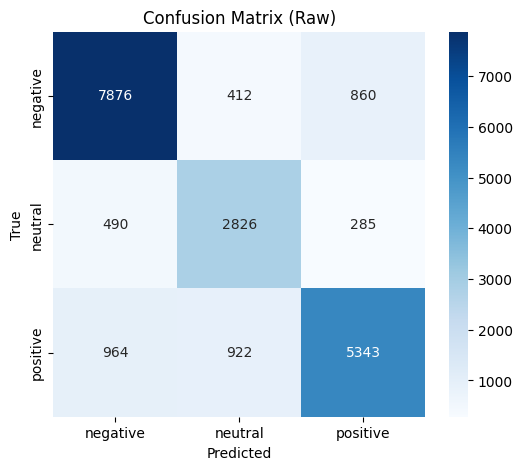

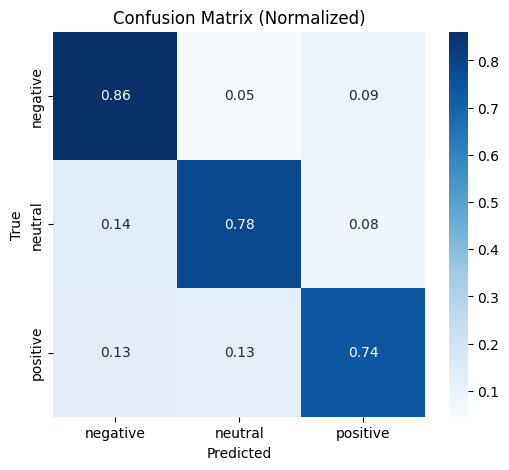


Classification Report (Tabular Form):

              precision    recall  f1-score       support
negative       0.844159  0.860953  0.852473   9148.000000
neutral        0.679327  0.784782  0.728257   3601.000000
positive       0.823520  0.739106  0.779033   7229.000000
accuracy       0.803133  0.803133  0.803133      0.803133
macro avg      0.782335  0.794947  0.786588  19978.000000
weighted avg   0.806980  0.803133  0.803509  19978.000000
Overall Accuracy: 0.8031334467914706
Per-class metrics:               precision    recall  f1-score       support
negative       0.844159  0.860953  0.852473   9148.000000
neutral        0.679327  0.784782  0.728257   3601.000000
positive       0.823520  0.739106  0.779033   7229.000000
accuracy       0.803133  0.803133  0.803133      0.803133
macro avg      0.782335  0.794947  0.786588  19978.000000
weighted avg   0.806980  0.803133  0.803509  19978.000000


In [ ]:
# cm, labels, preds = evaluate_model(model, test_loader, train_dataset.new_classes, device=device)

results = evaluate_model(resnet, test_loader, new_classes, device)

print("Overall Accuracy:", results["accuracy"])
print("Per-class metrics:", results["classification_report"])

# Test Model

In [ ]:
from google.colab import files
from PIL import Image
import torchvision.transforms as transforms
import torch

# Upload an image
uploaded = files.upload()  # will open file picker

# Load the uploaded file (just take the first file)
file_path = list(uploaded.keys())[0]
img = Image.open(file_path).convert("RGB")  # convert to 3 channels

# Transform (same as test_transform)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
img_t = transform(img).unsqueeze(0)  # add batch dimension

# Predict
resnet.eval()
with torch.no_grad():
    img_t = img_t.to(next(resnet.parameters()).device)
    output = resnet(img_t)
    _, pred = torch.max(output, 1)

classes = ['negative', 'neutral', 'positive']
print("Predicted class:", classes[pred.item()])


Saving 220_F_48883681_3YSVqKeyIvDNGZ9t0A8ynIFaeo64sHDm.jpg to 220_F_48883681_3YSVqKeyIvDNGZ9t0A8ynIFaeo64sHDm.jpg
Predicted class: negative


#Export Checkpoint to ONNX

In [ ]:
import onnx
dummy_input = torch.randn(1, 3, 224, 224).to(device)
onnx_path = "/content/emotion_model.onnx"

resnet.eval()

torch.onnx.export(
    resnet,
    dummy_input,
    onnx_path,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
    opset_version=11
)

print(f"ONNX model saved at {onnx_path}")
files.download(onnx_path)


/tmp/ipython-input-1471265024.py:7: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


ONNX model saved at /content/emotion_model.onnx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
## Get ONNX Details

In [ ]:
!pip install onnx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 69.5 MB/s eta 0:00:00


In [ ]:
import onnx
from google.colab import files
from PIL import Image
import torchvision.transforms as transforms
import torch

# Upload ONNX model
print("Upload your ONNX model file:")
uploaded_onnx = files.upload()  # File picker
onnx_file_path = list(uploaded_onnx.keys())[0]
print(f"Uploaded ONNX file: {onnx_file_path}")

# Load the ONNX model
model = onnx.load(onnx_file_path)
print("\n--- Model loaded ---\n")

# Print input and output node names
print("Model Inputs:")
for inp in model.graph.input:
    print(f"Name: {inp.name}, Type: {inp.type}")

print("\nModel Outputs:")
for out in model.graph.output:
    print(f"Name: {out.name}, Type: {out.type}")

# Upload an image
upload_image = input("\nDo you want to upload an image to check preprocessing? (y/n): ")
if upload_image.lower() == 'y':
    print("Upload your image file:")
    uploaded_img = files.upload()
    img_path = list(uploaded_img.keys())[0]

    # Load image
    img = Image.open(img_path).convert("RGB")

    # Example transform like in training
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    img_t = transform(img).unsqueeze(0)
    print(f"\nImage tensor shape: {img_t.shape}")
    print("Ready to pass to ONNX runtime with input name above.")


Upload your ONNX model file:


Saving emotion_model.onnx to emotion_model.onnx
Uploaded ONNX file: emotion_model.onnx

--- Model loaded ---

Model Inputs:
Name: input, Type: tensor_type {
  elem_type: 1
  shape {
    dim {
      dim_param: "batch_size"
    }
    dim {
      dim_value: 3
    }
    dim {
      dim_value: 224
    }
    dim {
      dim_value: 224
    }
  }
}


Model Outputs:
Name: output, Type: tensor_type {
  elem_type: 1
  shape {
    dim {
      dim_param: "batch_size"
    }
    dim {
      dim_value: 3
    }
  }
}


Do you want to upload an image to check preprocessing? (y/n): y
Upload your image file:


Saving 220_F_48883681_3YSVqKeyIvDNGZ9t0A8ynIFaeo64sHDm.jpg to 220_F_48883681_3YSVqKeyIvDNGZ9t0A8ynIFaeo64sHDm.jpg

Image tensor shape: torch.Size([1, 3, 224, 224])
Ready to pass to ONNX runtime with input name above.
